<a href="https://colab.research.google.com/github/rukmals/crowd-monitoring-system-model-development/blob/main/UCSD_Data_Set_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from tensorflow.keras.preprocessing import image

import scipy
from scipy.io import loadmat
import glob
import h5py
import time
from sklearn.externals.joblib import Parallel, delayed
from torchvision import datasets, transforms

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
test_setpath = "/content/drive/MyDrive/Model_Test_Data/UCSD/vidf-cvpr/vidf1_33_000_people_full.mat"

In [18]:
def gaussian_filter_density(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density
    #print(gt_count)
    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    pts_copy = pts.copy()
    tree = scipy.spatial.KDTree(pts_copy, leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)
    print('generate density...')
    #print(locations)
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1], pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1] + distances[i][2] + distances[i][3]) * 0.1
        else:
            sigma = np.average(np.array(gt.shape)) / 2. / 2.  # case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

In [4]:
mat_path = "/content/drive/MyDrive/Model_Test_Data/UCSD/vidf-cvpr/vidf1_33_000_frame_full.mat"
mat = scipy.io.loadmat(mat_path)

In [14]:
mat['frame'][0][0][0][0][2]

array([[-1.58865248,  0.36107193,  3.        ],
       [-0.68085106,  0.31593794,  3.        ],
       [-0.48632219,  0.45778763,  3.        ],
       [-0.50253293,  0.11605884,  3.        ],
       [-0.34042553,  0.02579085,  3.        ],
       [ 1.14285714, -0.43844449,  3.        ],
       [ 1.19148936, -0.40620592,  3.        ],
       [ 0.66464032, -0.34817651,  3.        ],
       [ 1.33738602, -0.19343139,  3.        ],
       [ 0.35355689, -0.44891279,  3.        ],
       [ 0.31634038, -0.23942015,  3.        ],
       [ 0.58616011, -0.31423895,  3.        ],
       [ 0.39077341, -0.20949264,  3.        ],
       [ 0.24190735, -0.06733692,  3.        ],
       [ 0.28842799, -0.31423895,  3.        ],
       [-0.45590231,  0.10474632,  3.        ],
       [ 0.63268075, -0.06733692,  3.        ]])

In [16]:
len(mat['frame'][0])

200

In [18]:
img_path = '/content/drive/MyDrive/Model_Test_Data/UCSD/ucsdpeds/vidf/vidf1_33_000.y/vidf1_33_000_f001.png'
imgfile = image.load_img(img_path)
img = image.img_to_array(imgfile)
k = np.zeros((img.shape[0], img.shape[1]))

In [24]:
for j in range(0, 10):
  mat_path = "/content/drive/MyDrive/Model_Test_Data/UCSD/vidf-cvpr/vidf1_33_00"+str(j)+"_frame_full.mat"
  mat = scipy.io.loadmat(mat_path)
  for i in range(len(mat['frame'][0])):
    gt = mat['frame'][0][i][0][0][0]
    if i<9:
      img_path = '/content/drive/MyDrive/Model_Test_Data/UCSD/ucsdpeds/vidf/vidf1_33_00'+str(j)+'.y/vidf1_33_00'+str(j)+'_f00'+str(i+1)+'.png'
    if i>=9 and i<99:
      img_path = '/content/drive/MyDrive/Model_Test_Data/UCSD/ucsdpeds/vidf/vidf1_33_00'+str(j)+'.y/vidf1_33_00'+str(j)+'_f0'+str(i+1)+'.png'
    if i>=99:
      img_path = '/content/drive/MyDrive/Model_Test_Data/UCSD/ucsdpeds/vidf/vidf1_33_00'+str(j)+'.y/vidf1_33_00'+str(j)+'_f'+str(i+1)+'.png'
    imgfile = image.load_img(img_path)
    img = image.img_to_array(imgfile)
    k = np.zeros((img.shape[0], img.shape[1]))
    for i in range(0, len(gt)):
      if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
        k[int(gt[i][1]), int(gt[i][0])] = 1
    k = gaussian_filter_density(k)
    output_path = img_path.replace('.png', '.h5').replace('vidf1_33_00'+str(j)+'.y/','vidf1_33_00'+str(j)+'.y/gt-h5/')
    output_dir = os.path.dirname(output_path)
    os.makedirs(output_dir, exist_ok=True)
    print("output", output_path)
    with h5py.File(output_path, 'w') as hf:
      hf['density'] = k
    print(img_path)
  print("done!!  "+"vidf1_33_00"+str(j))

Streaming output truncated to the last 5000 lines.
(158, 238)
generate density...
done.
output /content/drive/MyDrive/Model_Test_Data/UCSD/ucsdpeds/vidf/vidf1_33_005.y/gt-h5/vidf1_33_005_f002.h5
/content/drive/MyDrive/Model_Test_Data/UCSD/ucsdpeds/vidf/vidf1_33_005.y/vidf1_33_005_f002.png
(158, 238)
generate density...
done.
output /content/drive/MyDrive/Model_Test_Data/UCSD/ucsdpeds/vidf/vidf1_33_005.y/gt-h5/vidf1_33_005_f003.h5
/content/drive/MyDrive/Model_Test_Data/UCSD/ucsdpeds/vidf/vidf1_33_005.y/vidf1_33_005_f003.png
(158, 238)
generate density...
done.
output /content/drive/MyDrive/Model_Test_Data/UCSD/ucsdpeds/vidf/vidf1_33_005.y/gt-h5/vidf1_33_005_f004.h5
/content/drive/MyDrive/Model_Test_Data/UCSD/ucsdpeds/vidf/vidf1_33_005.y/vidf1_33_005_f004.png
(158, 238)
generate density...
done.
output /content/drive/MyDrive/Model_Test_Data/UCSD/ucsdpeds/vidf/vidf1_33_005.y/gt-h5/vidf1_33_005_f005.h5
/content/drive/MyDrive/Model_Test_Data/UCSD/ucsdpeds/vidf/vidf1_33_005.y/vidf1_33_005_f0

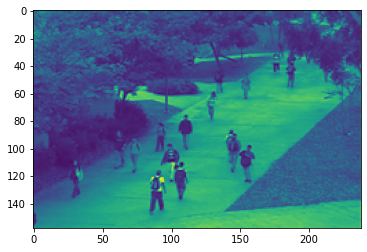

In [25]:
img_path = "/content/drive/MyDrive/Model_Test_Data/UCSD/ucsdpeds/vidf/vidf1_33_009.y/vidf1_33_009_f200.png"
from matplotlib import pyplot as plt
from matplotlib import cm as CM
import PIL.Image as Image
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_path))

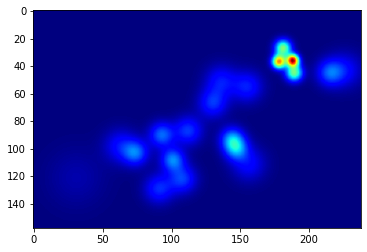

In [26]:

density_map_path = "/content/drive/MyDrive/Model_Test_Data/UCSD/ucsdpeds/vidf/vidf1_33_009.y/gt-h5/vidf1_33_009_f200.h5"
import h5py
gt_file = h5py.File(density_map_path,'r')
groundtruth = np.asarray(gt_file['density'])

plt.imshow(groundtruth,cmap=CM.jet)

In [27]:
print(np.sum(groundtruth))

19.885046
